# Generating the phantom and a sinogram

- Generate a phantom where each pixel consists of part bone and part water described as (bone, water)
    - Background values should be low for both to simulate air (0, 0.05)
    - main body should be elliptical and mainly consist of water (0.20, 0.80)
    - elliptical inserts should simulate different organs and/or body featurs (0.80, 0.80)

- Generate a sinogram from the projections
    - The function will return a 3D object containing the sinograms for the height of the detector. We want to select a slice to display
    - print a 2D cross section of the phantom with a corresponding sinogram

In [10]:
#settings
objectSize = 32     # size of the object
nPixelsY = 64       # number of pixels in Y direction detector
nPixelsZ = 44       # number of pixels in Z direction detector
projections = 64   # number of projections

## generate phantom

In [11]:
import random, numpy as np

def generate_ct_matrices(n, h, num_features=5):

    # Initialize 3D bone and water matrices with zeros
    bone_matrix = np.zeros((n, n, n), dtype=float)
    water_matrix = np.zeros((n, n, n), dtype=float)

    # fill background of matrices with 0.05 bone and water 
    bone_matrix.fill(0)
    water_matrix.fill(0.05)
    
    # set values for main ellipse (simulated torso)
    intensity_bone = 0.2
    intensity_water = 0.8
    
    # Main body ellipse (simulated torso)
    for i in range(h, n - h):
        for j in range(2 * h, n - 2 * h):
            if ((i - n//2) / ((n - 2 * h) / 2)) ** 2 + ((j - n//2) / ((n - 6 * h) / 2)) ** 2 <= 1:
                
                bone_matrix[2*h:-2*h, i, j] = intensity_bone
                water_matrix[2*h:-2*h, i, j] = intensity_water

    # Adding smaller features (e.g., organs or bone structures)
    for _ in range(num_features):
        
        # Random place in the body - h is the offset from the edge, n is the size of the matrix
        a = random.randint(h, (n - h) // 4)  # Semi-major axis
        b = random.randint(h, (n - h) // 4)  # Semi-minor axis
        center_x = random.randint(h + a, n - h - a)
        center_y = random.randint(3 * h + b, n - 3 * h - b)

        # Randomly choose the intensity for bone and water, together they add to 1. 
        bone_intensity = 0.8
        water_intensity = 0.8
        
        for i in range(center_x - a, center_x + a):
            for j in range(center_y - b, center_y + b):
                if 0 <= i < n and 0 <= j < n:
                    if ((i - center_x) / a) ** 2 + ((j - center_y) / b) ** 2 <= 1:
                        bone_matrix[2*h:-2*h, i, j] = bone_intensity
                        water_matrix[2*h:-2*h, i, j] = water_intensity
    water_matrix *= 1  # Water density is 1
    bone_matrix *= 1.92  # Apply bone density
    
    return bone_matrix, water_matrix

bone, water = generate_ct_matrices(objectSize, 2, num_features=3)
x = np.column_stack((bone.ravel(), water.ravel()))



## Running projection algorithm

In [12]:
from libs.simulatepreps import projectMatrix

#generate proection matrices
y, S, M, A = projectMatrix(x, objectSize, nPixelsY, nPixelsZ, 1, projections)

## Generating sinogram

In [13]:
def getSinogram(y, energy_bin_index=0, z_index=32, nProj=100, detector_shape=(64, 44)):  
    nX, nZ = detector_shape
    y_bin = y[energy_bin_index]
    y_proj_zx = y_bin.reshape((nProj, nZ, nX))  # shape: (100, 64, 44)
    sinogram = y_proj_zx[:, z_index, :]  # shape: (100, 44)
    return sinogram

sinogram = getSinogram(y, energy_bin_index=0, z_index=objectSize // 2, nProj=projections, detector_shape=(nPixelsY, nPixelsZ))


## Make figure

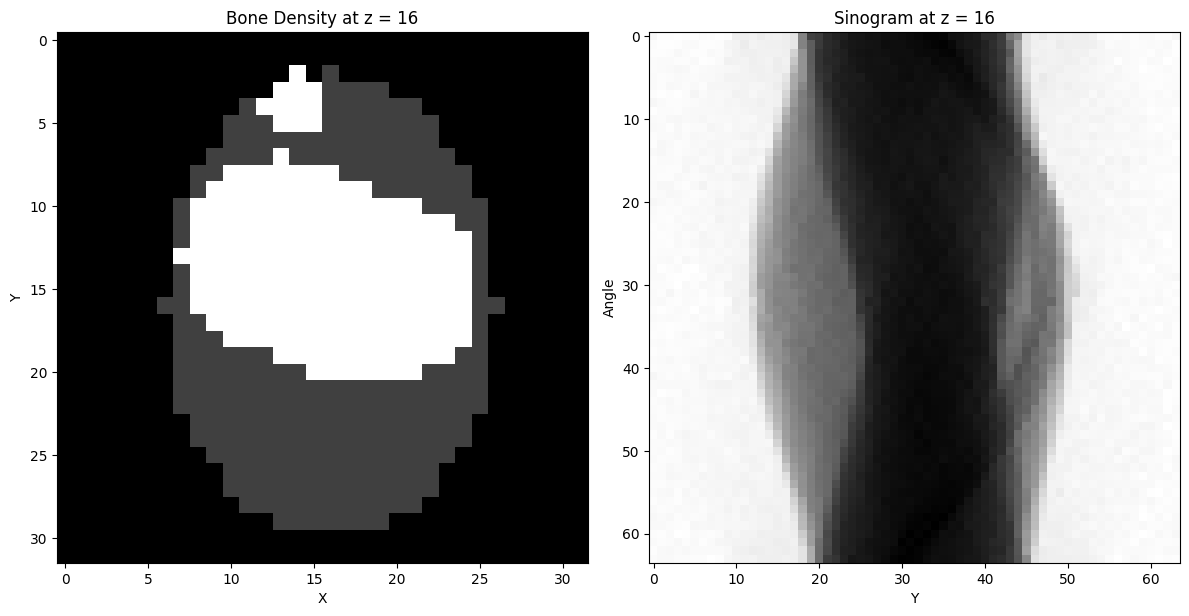

In [14]:
#| label: phantomAndSinogram

import matplotlib.pyplot as plt


# plot bone density and phantom at objectSize //2 
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(bone[objectSize // 2, :, :], cmap='gray')
plt.title('Bone Density at z = {}'.format(objectSize // 2))
plt.xlabel('X')
plt.ylabel('Y')

plt.subplot(1, 2, 2)
plt.imshow(sinogram, cmap='gray')
plt.title('Sinogram at z = {}'.format(objectSize // 2))
plt.ylabel('Angle')
plt.xlabel('Y')

plt.tight_layout()
plt.show()